**Importing all the important libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import  RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from lime import lime_tabular
from mediapipe_handler import MediaPipeHandler
import seaborn as sns
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE


**Workflow**
1. Loading Training and Testing Datasets
2. Add Label string values
3. Looking at workout distributions
4. Preprocessing
5. Feature Engineering
6. Train Random Forest with hyperparameters [with and without feature engineering]
7. Train Neural Network with hyperparameters [with and without feature engineering]
8. Train SVM with hyperparameters [with and without feature engineering]
9. Compare model performance in terms of SPEED,ACCURACY,PERCISION,RECALL,F1-SCORE
10. Do the same process but with SMOTE to handle imbalance classes, then compare accuracy

**1. Loading Training and Testing Datasets**

In [22]:
mediapipe_model = MediaPipeHandler()

training_dataset=mediapipe_model.read_csv_to_pd("/Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/data/train_new.csv")
testing_dataset=mediapipe_model.read_csv_to_pd("/Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/data/test_new.csv")

current OS working directory is /Users/yasinetawfeek/Developer/DesD_AI_pathway/AI/app


I0000 00:00:1745370812.899839 18184731 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745370812.968723 18853285 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745370812.982402 18853281 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


**3. Looking at Workout Distribution**

In [24]:
Workout_labels=training_dataset['muscle group'].unique()

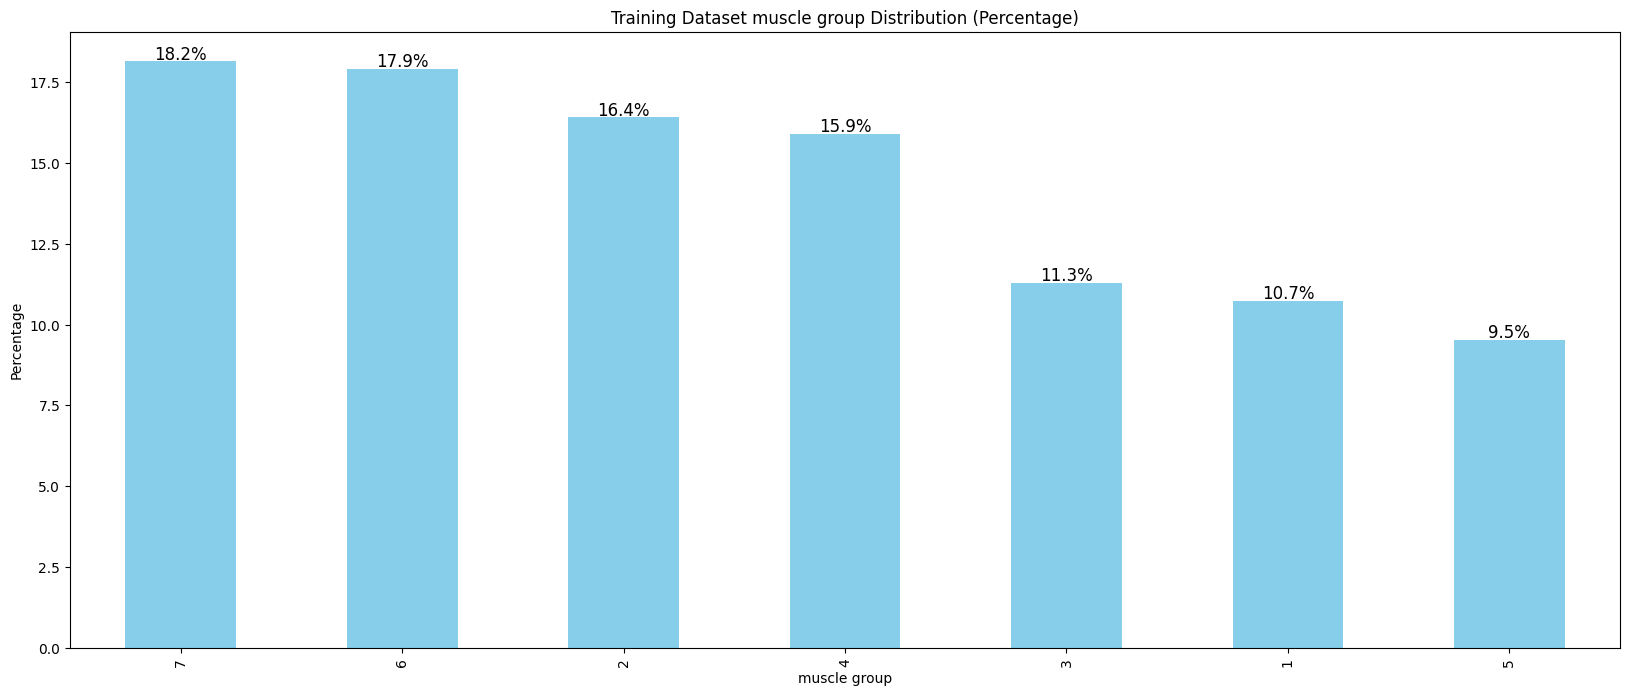

In [25]:
plt.figure(figsize=(20,8))
value_counts = training_dataset['muscle group'].value_counts()
percentages = value_counts / value_counts.sum() * 100

# Plot
ax = percentages.plot(kind='bar', color='skyblue')

# Add percentage text on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', fontsize=12, color='black', xytext=(0, 5), textcoords='offset points')

plt.title('Training Dataset muscle group Distribution (Percentage)')
plt.ylabel('Percentage')
plt.show()

**4. Preprocessing**

**We have to make sure that we get right of Unamed 0: column, as it just contains numerical index not very useful, might lead to overfitting if it is left**
- Get rid of Unnamed 0:
- Get rid of image
- Get rid of muscle group
- split each feature into x,y,z components, then remove that original feature


In [26]:
training_dataset

,Unnamed: 0,image,label,muscle group,left_shoulder,right_shoulder,left_elbow,right_elbow,left_wrist,right_wrist,...,left_hip,right_hip,left_knee,right_knee,left_ankle,right_ankle,left_heel,right_heel,left_foot_index,right_foot_index
0,0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,3,"[0.48724321, 0.32607397, 0.03823465]","[0.47637296, 0.32897246, -0.44769832]","[0.49943107, 0.49979961, 0.10968293]","[0.48374778, 0.51944339, -0.48367658]","[0.54193252, 0.61351043, 0.03811103]","[0.53540999, 0.63929105, -0.44418535]",...,"[0.49465266, 0.59731555, 0.15546437]","[0.48429281, 0.60619318, -0.15580556]","[0.50619853, 0.77945465, 0.33636418]","[0.50929534, 0.83506566, -0.00164121]","[0.26471427, 1.11078507, 0.79866259]","[0.48285651, 0.99253339, 0.25685766]","[0.69470365, 1.25437403, 0.43643153]","[0.45890734, 1.0164752, 0.27879611]","[0.54183131, 0.9964084, 0.55343175]","[0.51083988, 1.02983606, 0.16821307]"
1,1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,3,"[0.6058349, 0.46771342, -0.44548258]","[0.44322824, 0.45400628, -0.12252265]","[0.6211409, 0.74852443, -0.59723413]","[0.40588063, 0.68709606, -0.11695482]","[0.54435045, 0.71156621, -0.89880764]","[0.31560823, 0.67800248, -0.47947589]",...,"[0.54175067, 0.88429976, -0.11493598]","[0.45463082, 0.8554256, 0.11567549]","[0.49341086, 1.16786051, -0.14099999]","[0.41931698, 1.09622645, 0.36362186]","[0.48207492, 1.40022349, 0.22376277]","[0.42590046, 1.31257629, 0.82390684]","[0.49501544, 1.44489646, 0.25046244]","[0.43514258, 1.36015165, 0.86586481]","[0.4332293, 1.48004401, 0.08895551]","[0.37628469, 1.38541198, 0.73240483]"
2,2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,7,2,"[0.6294158, 0.60693624, 0.0126257]","[0.33125708, 0.7367838, -0.0547078]","[0.78453428, 0.54939657, -0.37512818]","[0.15058079, 0.79398841, -0.55885345]","[0.73835477, 0.19092051, -0.7428954]","[0.11879187, 0.35120064, -0.94952174]",...,"[0.7334922, 1.31830764, -0.02994539]","[0.47056222, 1.38228041, 0.07612471]","[0.79782959, 1.88547456, 0.01286128]","[0.53241746, 1.99035244, -0.03812468]","[0.8887707, 2.39956379, 0.3873224]","[0.63482538, 2.44126998, 0.12368068]","[0.89694474, 2.45834636, 0.42109564]","[0.65920985, 2.53843427, 0.14892717]","[0.87567288, 2.56563544, -0.07653191]","[0.71951252, 2.64044094, -0.40026978]"
3,3,<PIL.Image.Image image mode=RGB size=480x360 a...,15,6,"[0.51189166, 0.42491716, -0.24814801]","[0.500489, 0.44667459, 0.19117554]","[0.5423919, 0.56828576, -0.27638879]","[0.56256897, 0.58546137, 0.22286665]","[0.53352803, 0.71034729, -0.19538929]","[0.53151709, 0.69903457, 0.17651002]",...,"[0.65149039, 0.55012625, -0.133608]","[0.6297462, 0.55485684, 0.13391186]","[0.55268493, 0.68013572, -0.11711649]","[0.55421073, 0.74962371, 0.10345377]","[0.56307957, 0.91711193, -0.05391499]","[0.55523193, 0.89356011, 0.22098898]","[0.57910913, 0.96781844, -0.0546349]","[0.61136699, 0.90639236, 0.16074306]","[0.51594623, 0.99227299, -0.08809846]","[0.4951165, 0.94751191, 0.17006937]"
4,4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,12,4,"[0.70003915, 0.49466658, 0.20820341]","[0.71699975, 0.58051408, -0.26920145]","[0.68926412, 0.66075891, 0.2374849]","[0.70927566, 0.73644245, -0.20667425]","[0.72442007, 0.66883294, 0.11963387]","[0.76798123, 0.71318328, 0.02715713]",...,"[0.49972194, 0.4664664, 0.15232211]","[0.53802202, 0.50569099, -0.19587132]","[0.36872668, 0.55736494, 0.24973365]","[0.36720355, 0.56125992, -0.04727813]","[0.27526878, 0.5552664, 0.36932113]","[0.21794462, 0.59607667, 0.05616758]","[0.20531246, 0.55665553, 0.35273132]","[0.18781589, 0.58153898, 0.060615]","[0.23688503, 0.66830349, 0.31713471]","[0.26519591, 0.7134101, -0.05453924]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78574,78574,<PIL.JpegImagePlugin.JpegImageFile image mode=...,18,6,"[0.59128084, 0.41358945, 0.0012454]","[0.37133779, 0.41908548, 0.00422132]","[0.63876867, 0.61237866, -0.18860631]","[0.20842998, 0.58728266, -0.32784112]","[0.65201691, 0.

In [27]:
training_dataset['left_ankle']

0         [0.26471427, 1.11078507, 0.79866259]
1         [0.48207492, 1.40022349, 0.22376277]
2           [0.8887707, 2.39956379, 0.3873224]
3        [0.56307957, 0.91711193, -0.05391499]
4          [0.27526878, 0.5552664, 0.36932113]
                         ...                  
78574     [0.51100039, 1.40979016, 0.30965364]
78575    [0.47206247, 0.72545171, -0.15951698]
78576    [0.47100398, 0.50265288, -0.14365949]
78577     [0.49809691, 1.06466457, 0.39905389]
78578     [0.57253718, 0.8895936, -0.04343893]
Name: left_ankle, Length: 78579, dtype: object

In [28]:
"""
Removes original feature and splits it into x,y,z components

"""
def Preprocess_data(dataframe,columns_to_flatten):
    final_df=dataframe.copy()
    # Expanding each column into 3 separate columns (x, y, z) and appending it to the final dataframe.
    for column in columns_to_flatten:
        # print(np.vstack(dataframe[column]).astype(float))
        expanded_df=pd.DataFrame(np.vstack(dataframe[column]).astype(float), 
                           columns=[column+'_x', column+'_y', column+'_z'],
                           index=dataframe.index)
        new_df = pd.concat([dataframe.drop(column, axis=1), expanded_df], axis=1)
        for new_column in new_df.columns:
            final_df[new_column] = new_df[new_column]

    return final_df.drop(columns=columns_to_flatten,axis=1)

"""
Splits dataset into X_train,y_train or X_test,y_test, if you give it training dataset then X_train and y_train

"""
def Return_X_y(dataframe,columns_to_delete):
    X=dataframe.drop(columns=columns_to_delete)
    y=dataframe['muscle group']
    return X,y

In [29]:
features_to_split=['left_shoulder',
       'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist',
       'right_wrist', 'left_pinky', 'right_pinky', 'left_index', 'right_index',
       'left_thumb', 'right_thumb', 'left_hip', 'right_hip', 'left_knee',
       'right_knee', 'left_ankle', 'right_ankle', 'left_heel', 'right_heel',
       'left_foot_index', 'right_foot_index']

training_dataset_preprocessed=Preprocess_data(training_dataset,features_to_split)
X_train, y_train = Return_X_y(training_dataset_preprocessed,['label','muscle group','image','Unnamed: 0'])


testing_dataset_preprocessed=Preprocess_data(testing_dataset,features_to_split)
X_test, y_test = Return_X_y(testing_dataset_preprocessed,['label','muscle group','image','Unnamed: 0'])

In [30]:
print("X_train Shape",X_train.shape)

print("y_train Shape",y_train.shape)

print("X_test Shape",X_test.shape)

print("y_test Shape",y_test.shape)

X_train Shape (78579, 66)
y_train Shape (78579,)
X_test Shape (11286, 66)
y_test Shape (11286,)


**66 Features is all the features**

**5. Feature Engineering**

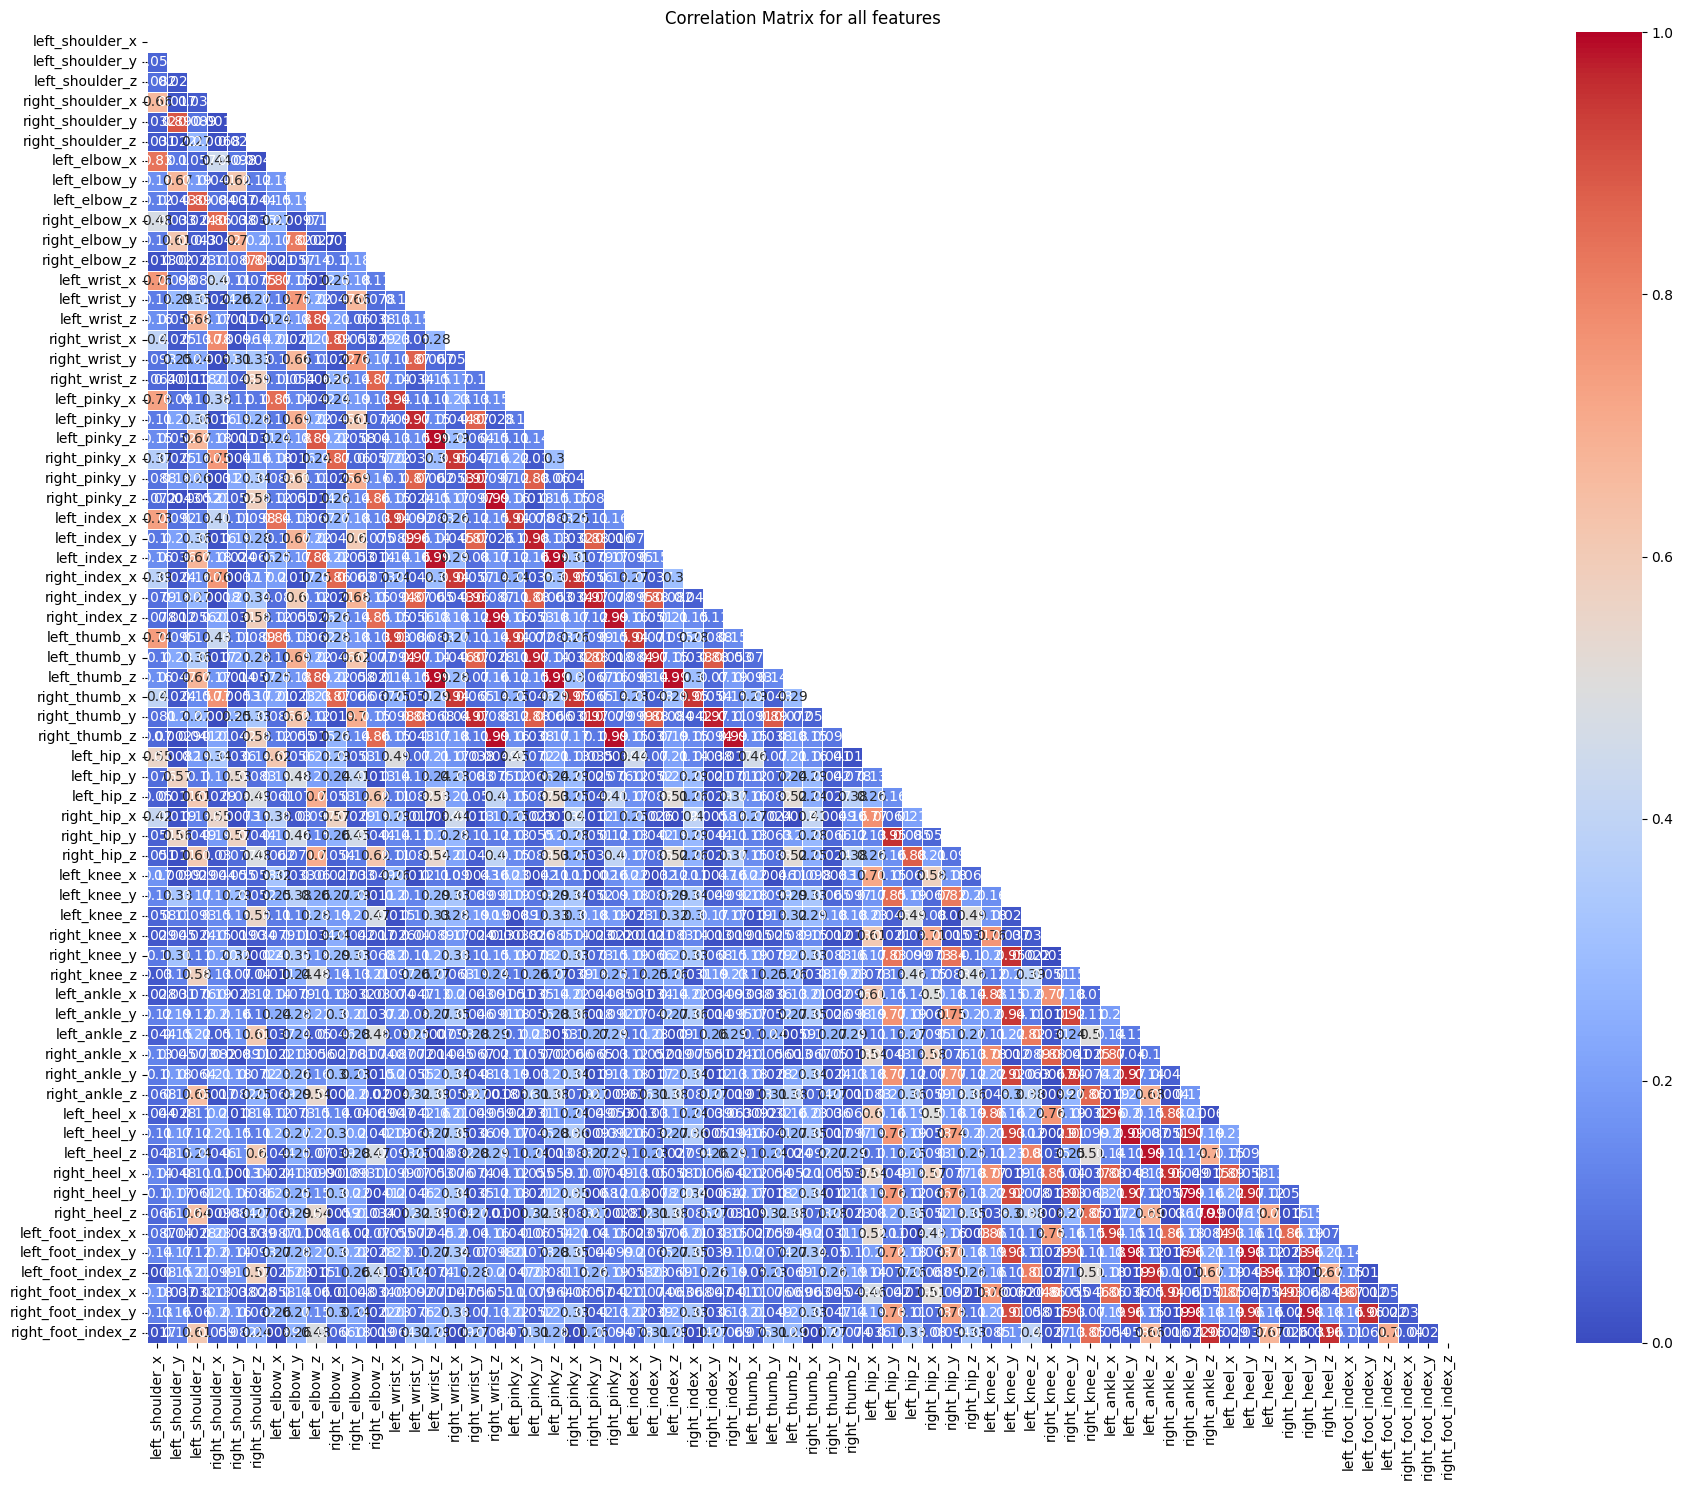

In [31]:
corr_matrix = X_train.corr().abs()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(24, 15))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', 
            vmax=1.0, vmin=0, center=0.5,
            square=True, linewidths=.5, annot=True).set(title='Correlation Matrix for all features')
plt.tight_layout()
plt.show()

**Features that are highly correlated , one of them should be removed**
- it is better to remove the one that is the least correlated with y_target

In [32]:
correlation_threshold = 0.8
columns_to_drop = []

for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > correlation_threshold:
            columns_to_drop.append(corr_matrix.columns[j])
            print(f"High Correlation between {corr_matrix.columns[i]} and {corr_matrix.columns[j]} --> {corr_matrix.iloc[i, j]:.2f}")

columns_to_drop = list(set(columns_to_drop))
print(f"Columns to drop: {columns_to_drop}")
print(f"number of columns to drop: {len(columns_to_drop)}")

High Correlation between left_shoulder_x and left_elbow_x --> 0.83
High Correlation between left_shoulder_y and right_shoulder_y --> 0.89
High Correlation between left_shoulder_z and left_elbow_z --> 0.89
High Correlation between right_shoulder_x and right_elbow_x --> 0.86
High Correlation between right_shoulder_z and right_elbow_z --> 0.84
High Correlation between left_elbow_x and left_wrist_x --> 0.87
High Correlation between left_elbow_x and left_pinky_x --> 0.85
High Correlation between left_elbow_x and left_index_x --> 0.84
High Correlation between left_elbow_x and left_thumb_x --> 0.85
High Correlation between left_elbow_y and right_elbow_y --> 0.82
High Correlation between left_elbow_z and left_wrist_z --> 0.89
High Correlation between left_elbow_z and left_pinky_z --> 0.89
High Correlation between left_elbow_z and left_index_z --> 0.88
High Correlation between left_elbow_z and left_thumb_z --> 0.89
High Correlation between right_elbow_x and right_wrist_x --> 0.89
High Correlati

In [33]:
print(f"Columns to drop: {columns_to_drop}")


Columns to drop: ['right_foot_index_z', 'right_ankle_x', 'right_thumb_z', 'right_pinky_x', 'left_pinky_y', 'right_hip_z', 'left_wrist_x', 'left_ankle_x', 'left_foot_index_y', 'right_ankle_z', 'left_heel_z', 'left_pinky_z', 'right_heel_x', 'right_index_x', 'right_foot_index_y', 'left_elbow_z', 'left_pinky_x', 'right_ankle_y', 'left_foot_index_z', 'left_index_x', 'right_index_y', 'left_heel_x', 'right_heel_y', 'right_wrist_x', 'left_index_z', 'right_knee_y', 'right_hip_y', 'right_wrist_z', 'left_heel_y', 'right_elbow_x', 'right_thumb_x', 'right_pinky_y', 'left_wrist_z', 'right_foot_index_x', 'right_pinky_z', 'left_thumb_y', 'left_thumb_x', 'right_elbow_z', 'right_index_z', 'right_heel_z', 'right_thumb_y', 'left_elbow_x', 'left_index_y', 'right_shoulder_y', 'left_knee_y', 'left_thumb_z', 'left_foot_index_x', 'right_wrist_y', 'right_elbow_y', 'left_ankle_y', 'left_ankle_z']


**53 Columns to drop**

In [34]:
X_train_feature_eng=X_train.drop(columns=columns_to_drop)
X_test_feature_eng=X_test.drop(columns=columns_to_drop)

In [35]:
X_train_feature_eng

,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_z,left_elbow_y,left_wrist_y,left_hip_x,left_hip_y,left_hip_z,right_hip_x,left_knee_x,left_knee_z,right_knee_x,right_knee_z
0,0.487243,0.326074,0.038235,0.476373,-0.447698,0.499800,0.613510,0.494653,0.597316,0.155464,0.484293,0.506199,0.336364,0.509295,-0.001641
1,0.605835,0.467713,-0.445483,0.443228,-0.122523,0.748524,0.711566,0.541751,0.884300,-0.114936,0.454631,0.493411,-0.141000,0.419317,0.363622
2,0.629416,0.606936,0.012626,0.331257,-0.054708,0.549397,0.190921,0.733492,1.318308,-0.029945,0.470562,0.797830,0.012861,0.532417,-0.038125
3,0.511892,0.424917,-0.248148,0.500489,0.191176,0.568286,0.710347,0.651490,0.550126,-0.133608,0.629746,0.552685,-0.117116,0.554211,0.103454
4,0.700039,0.494667,0.208203,0.717000,-0.269201,0.660759,0.668833,0.499722,0.466466,0.152322,0.538022,0.368727,0.249734,0.367204,-0.047278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78574,0.591281,0.413589,0.001245,0.371338,0.004221,0.612379,0.391550,0.516673,0.847133,0.050859,0.378284,0.513358,0.017813,0.338628,0.042689
78575,0.760395,0.503067,-0.276546,0.467085,0.221736,0.285939,0.185458,0.472036,0.413365,-0.094842,0.448569,0.464473,-0.152089,0.445203,0.064047
78576,0.439949,0.380806,-0.056802,0.417775,-0.154881,0.442916,0.491219,0.397274,0.447083,0.000373,0.380091,0.423209,-0.106145,0.421355,-0.108732
78577,0.586243,0.329328,-0.256882,0.372520,-0.237685,0.526039,0.639148,0.544436,0.652551,-0.054866,0.421616,0.526528,0.035132,0.411264,0.109172


In [36]:
X_train.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z',
       'left_elbow_x', 'left_elbow_y', 'left_elbow_z', 'right_elbow_x',
       'right_elbow_y', 'right_elbow_z', 'left_wrist_x', 'left_wrist_y',
       'left_wrist_z', 'right_wrist_x', 'right_wrist_y', 'right_wrist_z',
       'left_pinky_x', 'left_pinky_y', 'left_pinky_z', 'right_pinky_x',
       'right_pinky_y', 'right_pinky_z', 'left_index_x', 'left_index_y',
       'left_index_z', 'right_index_x', 'right_index_y', 'right_index_z',
       'left_thumb_x', 'left_thumb_y', 'left_thumb_z', 'right_thumb_x',
       'right_thumb_y', 'right_thumb_z', 'left_hip_x', 'left_hip_y',
       'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z',
       'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x',
       'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y',
       'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z',
       'lef

In [37]:
X_train_feature_eng.columns
# y_train.columns

Index(['left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z',
       'right_shoulder_x', 'right_shoulder_z', 'left_elbow_y', 'left_wrist_y',
       'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'left_knee_x',
       'left_knee_z', 'right_knee_x', 'right_knee_z'],
      dtype='object')

In [38]:
"""
This function takes both training_dataset
then it will show the result for each one of the models

1-Accuracy
2-Classification Report
3-Confusion Matrix
4-Precision, Recall, F1-Score
5-Time Taken to train
6-Features used to build the model

"""

def train_model(model,param_grid,X_train,y_train,X_test,y_test):
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=3,  # 5-fold cross-validation
        n_jobs=-1,  # Use all available cores
        verbose=2,
        scoring='accuracy'
    )
    grid_search.fit(X_train,y_train)
    y_predictions=grid_search.predict(X_test)
    accuracy = accuracy_score(y_test,y_predictions)
    report = classification_report(y_test,y_predictions)
    confusion_matrix_values = confusion_matrix(y_test,y_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_values, annot=True, fmt='d', cmap='Blues', cbar=True, 
                xticklabels=Workout_labels,
                yticklabels=Workout_labels)

    # Add labels, title, and axis ticks
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix Heatmap')

    # Show the plot
    plt.show()
    print("Best Parameters:", grid_search.best_params_)
    print("Accuracy:", (accuracy*100),"%")
    print("Classification Report:\n", report)

**Random Forest**

In [39]:
param_grid = {
    'n_estimators': [1000],
    'max_depth': [20],
    # 'min_samples_split': [2, 5, 10],
    # 'min_samples_leaf': [1, 2, 4],
    # 'max_features': ['sqrt', 'log2', None]
}



**Random Forest with no feature engineering**

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....................max_depth=20, n_estimators=1000; total time= 4.6min
[CV] END ....................max_depth=20, n_estimators=1000; total time= 4.6min
[CV] END ....................max_depth=20, n_estimators=1000; total time= 4.6min


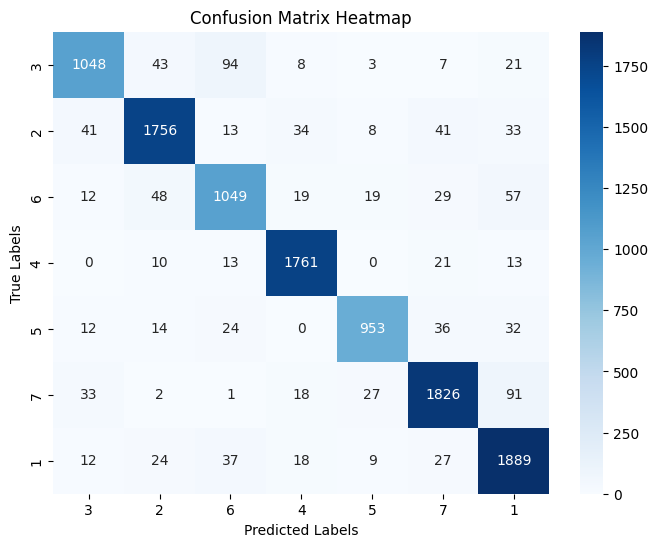

Best Parameters: {'max_depth': 20, 'n_estimators': 1000}
Accuracy: 91.10402268297005 %
Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.86      0.88      1224
           2       0.93      0.91      0.92      1926
           3       0.85      0.85      0.85      1233
           4       0.95      0.97      0.96      1818
           5       0.94      0.89      0.91      1071
           6       0.92      0.91      0.92      1998
           7       0.88      0.94      0.91      2016

    accuracy                           0.91     11286
   macro avg       0.91      0.90      0.91     11286
weighted avg       0.91      0.91      0.91     11286



In [40]:
random_tree_model = RandomForestClassifier(random_state=42)
train_model(random_tree_model,param_grid,X_train,y_train,X_test,y_test)

**Random Forest with feature engineering**

In [41]:
train_model(random_tree_model,param_grid,X_train_feature_eng,y_train,X_test_feature_eng,y_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END ....................max_depth=20, n_estimators=1000; total time= 1.9min
[CV] END ....................max_depth=20, n_estimators=1000; total time= 1.9min
[CV] END ....................max_depth=20, n_estimators=1000; total time= 1.9min


KeyboardInterrupt: 

**Multilayer Perceptron**

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],  
    # 'activation': ['relu', 'tanh'],  
    # 'solver': ['adam', 'sgd'],  
    # 'alpha': [0.0001, 0.001, 0.01],  
    # 'learning_rate': ['constant', 'adaptive'],  
    # 'max_iter': [200, 500, 1000]  
}

**Multilayer Perceptron with no feature engineering**

In [ ]:
mlp_model = MLPClassifier(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

train_model(mlp_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

**Multilayer Perceptron with feature engineering**

In [ ]:
mlp_model = MLPClassifier(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feature_eng)
X_test_scaled = scaler.fit_transform(X_test_feature_eng)

train_model(mlp_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

**Support Vector Machines**

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],  
    'kernel': ['linear', 'rbf'],  
    'gamma': ['scale', 'auto'],  
}

In [ ]:
svc_model = SVC(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

train_model(svc_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

In [ ]:
svc_model = SVC(random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_feature_eng)
X_test_scaled = scaler.fit_transform(X_test_feature_eng)

train_model(svc_model,param_grid,X_train_scaled,y_train,X_test_scaled,y_test)

**Upsampling the training dataset, then comparing the results to above**
- Applying SMOTE to make sure all classes are evenly distributed